In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

In [3]:
boston = load_boston()

In [4]:
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [5]:
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [7]:
prefix = 'boston-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [8]:
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


In [10]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [11]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-03-24 10:21:11 Starting - Starting the training job...
2020-03-24 10:21:13 Starting - Launching requested ML instances...
2020-03-24 10:22:11 Starting - Preparing the instances for training......
2020-03-24 10:22:58 Downloading - Downloading input data...
2020-03-24 10:23:41 Training - Training image download completed. Training in progress.
2020-03-24 10:23:41 Uploading - Uploading generated training modelArguments: train
[2020-03-24:10:23:36:INFO] Running standalone xgboost training.
[2020-03-24:10:23:36:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8498.27mb
[2020-03-24:10:23:36:INFO] Determined delimiter of CSV input is ','
[10:23:36] S3DistributionType set as FullyReplicated
[10:23:36] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-24:10:23:36:INFO] Determined delimiter of CSV input is ','
[10:23:36] S3DistributionType set as FullyReplicated
[10:23:36] 112x13 ma

In [12]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [13]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [14]:
xgb_transformer.wait()

...................Arguments: serve
[2020-03-24 10:27:45 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-03-24 10:27:45 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
Arguments: serve
[2020-03-24 10:27:45 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-03-24 10:27:45 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-03-24 10:27:45 +0000] [1] [INFO] Using worker: gevent
[2020-03-24 10:27:45 +0000] [38] [INFO] Booting worker with pid: 38
[2020-03-24 10:27:45 +0000] [39] [INFO] Booting worker with pid: 39
[2020-03-24 10:27:45 +0000] [40] [INFO] Booting worker with pid: 40
[2020-03-24 10:27:45 +0000] [41] [INFO] Booting worker with pid: 41
[2020-03-24:10:27:45:INFO] Model loaded successfully for worker : 39
[2020-03-24:10:27:45:INFO] Model loaded successfully for worker : 38
[2020-03-24:10:27:45:INFO] Model loaded successfully for worker : 40
[2020-03-24:10:27:45:INFO] Model loaded successfully for worker : 41
[2020-03-24 10:27:45 +0000] [1] [INFO] Using worker: geve

In [15]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-ap-south-1-185650036310/xgboost-2020-03-24-10-24-31-861/test.csv.out to ../data/boston/test.csv.out


In [16]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median Price vs Predicted Price')

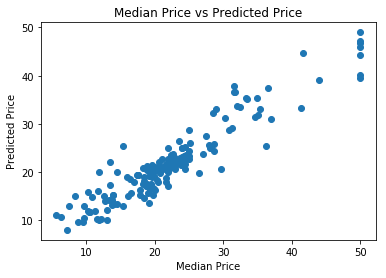

In [17]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [18]:
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir